In [1]:
%reload_ext autoreload
%autoreload

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN

import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
from functools import partial

import nomad.stop_detection.utils as utils
from nomad.stop_detection.utils import summarize_stop

import geopandas as gpd
import nomad.visit_attribution as visits
import nomad.filters as filters
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1
import matplotlib.pyplot as plt

In [3]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)

# longitude and latitude are also broken!
sparse_df.loc[:,'x'] = sparse_df['x'] - 2*(4265699)
sparse_df.loc[:,'y'] = sparse_df['y'] + 2*(4392976)

diaries_df.loc[:,'x'] = diaries_df['x'] - 2*(4265699)
diaries_df.loc[:,'y'] = diaries_df['y'] + 2*(4392976)

## Analyze completeness

In [4]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

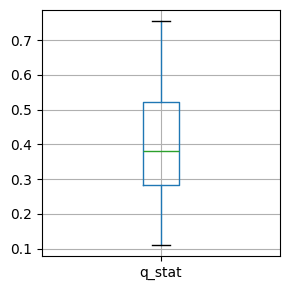

In [5]:
plt.figure(figsize=(3,3))
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

## Example for one user

In [6]:
# Select data from 1 user
user1 = diaries_df.uid.unique()[0]

sparse1 = sparse_df.loc[sparse_df['uid'] == user1]
diary1 = diaries_df.loc[diaries_df.uid == user1]

In [7]:
%%time
DUR_MIN=5
DT_MAX=90
DELTA_ROAM=30
# to summarize stops after groupby passing through individual locations
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id']) # < function(grouped_data)

# If we want to use 'majority' to attribute visits, then we need stop labels on each ping
labels_hdbscan = HDBSCAN.hdbscan_labels(traj=sparse1,
                                            time_thresh=100,
                                            min_pts=2,
                                            min_cluster_size=3,
                                            traj_cols=traj_cols)
labels_hdbscan.name = 'cluster'
# join with the original data
sparse_with_cluster = sparse1.join(labels_hdbscan)

# has same index as data
pred_hdbscan = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
pred = sparse_with_cluster.join(pred_hdbscan)

stop_table_hdbscan = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
stop_table_hdbscan.head()

CPU times: total: 609 ms
Wall time: 609 ms


,cluster,x,y,start_timestamp,duration,building_id
0,1,-4.265481e+06,4.393192e+06,1704148860,45,h-x13-y13
1,2,-4.265484e+06,4.393195e+06,1704158220,199,h-x13-y13
2,3,-4.265486e+06,4.393120e+06,1704216600,97,h-x13-y9
3,4,-4.265627e+06,4.393140e+06,1704253920,227,w-x3-y10
4,5,-4.265637e+06,4.393218e+06,1704287400,34,w-x3-y16


In [8]:
%%time
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
stop_detection_algos = ['oracle', 'lachesis', 'ta-dbscan', 'hdbscan']
stop_detection_algos = ['oracle', 'lachesis']

metrics_df = pd.DataFrame()
TIME_THRESH=240
DIST_THRESH=20
MIN_PTS=2

DUR_MIN=5
DT_MAX=240
DELTA_ROAM=30

for user in diaries_df.uid.unique()[:100]:
    for algo in stop_detection_algos:
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df.loc[diaries_df['uid'] == user].copy()
        
        if algo == 'oracle':
            # oracle says correct poi for each ping
            location = visits.oracle_map(
                sparse,
                truth,
                timestamp='timestamp',
                location_id='building_id')
            # find cluster labels with naive grid-based continuity
            labels = GRID_BASED.grid_based_labels(
                data=sparse.join(location),
                time_thresh=TIME_THRESH,
                min_pts=0, #we allow stops of duration 0, patched later
                location_id='building_id',
                traj_cols=traj_cols)
        
        elif algo == 'lachesis':
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            
            labels.name = 'cluster'           
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'ta-dbscan':
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'hdbscan':
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
        else:
            print(f"Algorithm {algo} not in the list!")

        # ----------- COMPUTE STOPS FROM LABELS -----------------------
        if algo != 'oracle': 
            pred = visits.point_in_polygon(data=sparse_with_cluster,
                                            poi_table=poi_table,
                                            method='majority',
                                            data_crs='EPSG:3857',
                                            max_distance=15,
                                            cluster_label='cluster',
                                            location_id='building_id',
                                            x='x',
                                            y='y')
        
            pred = sparse_with_cluster.join(pred)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            
        else: #location exists by oracle, we join everything
            pred = sparse.join(location).join(labels)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            # we add a 5min duration to oracle stops with just one ping
            stops = utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp = 'start_timestamp') 

        
        # ----------- COMPUTE METRICS OF INTEREST -----------------------
        # Step 1: Compute overlaps
        overlaps = overlapping_visits(left=stops,
                                      right=truth,
                                      location_id='building_id',
                                      match_location=False)

        # Step 2: Compute visitation errors (missed, merged, split)
        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

        # Step 3: Compute precision, recall, and F1
        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')

        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        metrics_df = pd.concat([metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

CPU times: total: 46.3 s
Wall time: 46.3 s


In [9]:
metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
algorithm,,,,,,
lachesis,0.686933,0.027262,0.091573,0.997286,0.299702,0.44207
oracle,0.606378,0.009900,0.016429,0.998004,0.319353,0.46346


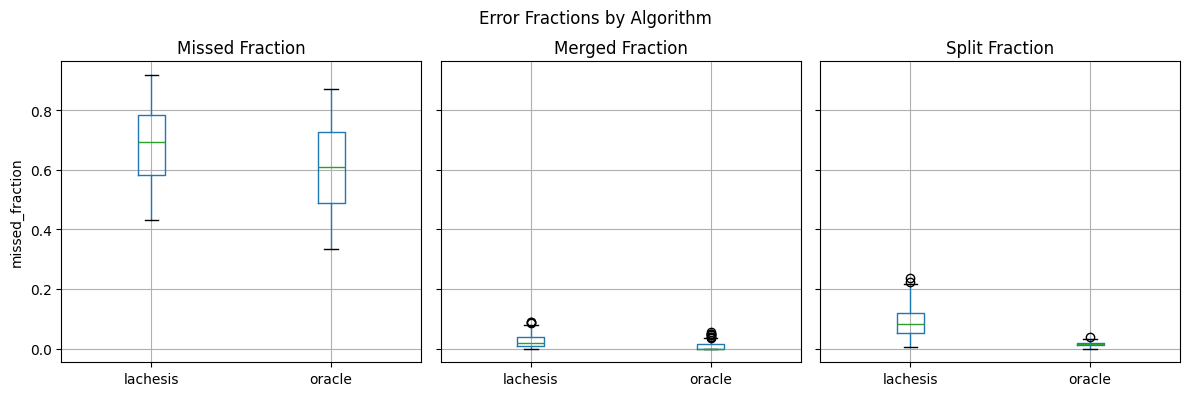

In [10]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.suptitle("Error Fractions by Algorithm")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

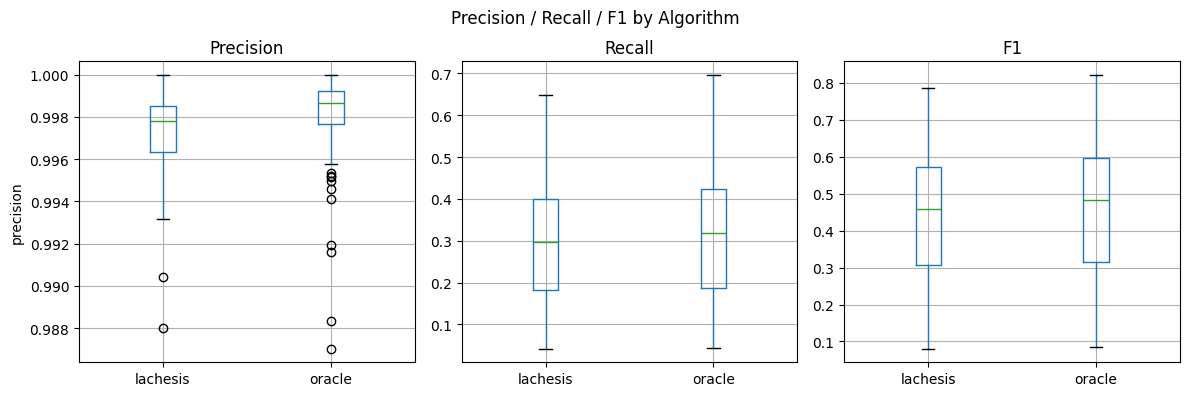

In [11]:
prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, metric in zip(axes, prf_metrics):
    metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.upper() if metric=="f1" else metric.title())
    ax.set_xlabel("")
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.grid(True)
fig.suptitle("Precision / Recall / F1 by Algorithm")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

## Exploration of building size

In [25]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building(building):
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

building_sizes = {
    b_id: classify_building(b_obj)
    for b_id, b_obj in city.buildings.items()
}

building_sizes

def clasify_dwell(stop_table):
    # (low, mid, high)
    return

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.box(on=True)

# Plotting Garden City Map

city.plot_city(ax, doors=True, address=True)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [27]:
city.buildings['r-x5-y0'].blocks

[(5, 1)]

In [ ]:
city.buildings

## Usage of oracle_map and location_based stop detection

In [29]:
# Select data from 1 user
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id'])
user = diaries_df.uid.unique()[1]

sparse = sparse_df.loc[sparse_df['uid'] == user]
truth = diaries_df.loc[diaries_df.uid == user]

In [30]:
user

'adoring_keldysh'

In [31]:
location = visits.oracle_map(sparse, truth, timestamp='timestamp', location_id='building_id')

In [32]:
labels = GRID_BASED.grid_based_labels(data=sparse.join(location),
                             time_thresh=240,
                             min_pts=0,
                             datetime='local_timestamp',
                             location_id='building_id')
pred = sparse.join(location).join(labels)

In [33]:
stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
stops = utils.pad_short_stops(stops, pad=5, start_timestamp = 'start_timestamp') # we add a little duration to oracle stops with just one ping

In [34]:
# Step 1: Compute overlaps
overlaps = overlapping_visits(left=stops,
                              right=truth,
                              location_id='building_id',
                              match_location=False)

# Step 2: Compute visitation errors (missed, merged, split)
errors = compute_visitation_errors(overlaps=overlaps,
                                   true_visits=truth,
                                   location_id='building_id')

# Step 3: Compute precision, recall, and F1
prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                   pred_visits=stops,
                                   true_visits=truth,
                                   location_id='building_id')

In [35]:
print(errors)
print(prf1)

{'missed_fraction': 0.8926174496644296, 'merged_fraction': 0.0, 'split_fraction': 0.0044742729306487695}
{'precision': 0.9997248968363136, 'recall': 0.1310966810966811, 'f1': 0.23179716153723487}
